In [ ]:
## Initial Setup, RDKit

!pip install rdkit==2023.03.01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 3.1 MB/s eta 0:00:00


In [ ]:
## Generate Gaussian input file from SMILES string
## Example: Ethanol

from rdkit import Chem
from rdkit.Chem import AllChem

# Create a molecule from a SMILES string
ethanol = Chem.MolFromSmiles('CCO')

# Generate 3D coordinates
ethanol = Chem.AddHs(ethanol)
AllChem.EmbedMolecule(ethanol)
AllChem.MMFFOptimizeMolecule(ethanol)

# Generate Gaussian input file
with open('ethanol.gjf', 'w') as f:
    f.write('%nproc=4\n')  # Number of CPU cores to be used
    f.write('%mem=4GB\n')  # Memory size to be used
    f.write('# B3LYP/6-31G(d) Opt Freq\n\n')  # Calculation method and basis set
    f.write('Ethanol geometry optimization\n\n')  # Job description
    f.write('0 1\n')  # Charge and spin multiplicity

    # Write atom coordinates to the input file
    conf = ethanol.GetConformer()
    for atom in ethanol.GetAtoms():
        pos = conf.GetAtomPosition(atom.GetIdx())
        f.write(f'{atom.GetSymbol()}    {pos.x}    {pos.y}    {pos.z}\n')

    f.write('\n\n')
    f.close()

In [ ]:
## Generate Gaussian input file while accepting SMILES string as input

from rdkit import Chem
from rdkit.Chem import AllChem

# Accept SMILES code as input
smiles = input("Enter the SMILES code of the molecule: ")
filename = input("Enter the desired filename for the Gaussian input file: ")

# Ensure filename ends in gjf (Gaussian Input File type)
if filename.split('.')[-1] != 'gjf':
  filename = filename + '.gjf'

# Create a molecule from the SMILES code
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)
AllChem.MMFFOptimizeMolecule(mol)

# Generate the Gaussian input file
with open(filename, 'w') as f:
    f.write('%nproc=4\n')  # Number of CPU cores to be used
    f.write('%mem=4GB\n')  # Memory size to be used
    f.write('# B3LYP/6-31G(d) Opt Freq\n\n')  # Calculation method and basis set
    f.write(f'{smiles} geometry optimization\n\n')  # Job description
    f.write('0 1\n')  # Charge and spin multiplicity

    conf = mol.GetConformer()
    for atom in mol.GetAtoms():
        pos = conf.GetAtomPosition(atom.GetIdx())
        f.write(f'{atom.GetSymbol()}    {pos.x}    {pos.y}    {pos.z}\n')

    f.write('\n\n')


Enter the SMILES code of the molecule: C(C(O[N+](=O)O)O[N+](=O)O)(O[N+](=O)O)O[N+](=O)O
Enter the desired filename for the Gaussian input file: azanium


In [ ]:
## Initial Setup, PubChemPy (API interaction with PubChem)

!pip install pubchempy==1.0.4

  Preparing metadata (setup.py) ... done
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13820 sha256=8ce77a99ce9f1ff020d4d2168e0cc6375d09f20849e4b80ed167703d477b8c8a
  Stored in directory: /root/.cache/pip/wheels/90/7c/45/18a0671e3c3316966ef7ed9ad2b3f3300a7e41d3421a44e799
Successfully built pubchempy


In [ ]:
## Use PubChemPy to search for molecule and create Gaussian input file

import pubchempy as pcp
from rdkit import Chem
from rdkit.Chem import AllChem


# Accept the name of the molecule as input
name = input("Enter the name of the molecule: ")
filename = input("Enter the desired filename for the Gaussian input file: ")

# Ensure filename ends in gjf (Gaussian Input File type)
if filename.split('.')[-1] != 'gjf':
  filename = filename + '.gjf'

# Search for the compound using the molecule name in PubChem
compounds = pcp.get_compounds(name, 'name')

# Get the SMILES code of the first compound obtained from the search
smiles = compounds[0].isomeric_smiles

# Create a molecule from the SMILES code
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)
AllChem.MMFFOptimizeMolecule(mol)

# Generate the Gaussian input file
with open(filename, 'w') as f:
    f.write('%nproc=4\n')  # Number of CPU cores to be used
    f.write('%mem=4GB\n')  # Memory size to be used
    f.write('# B3LYP/6-31G(d) Opt Freq\n\n')  # Calculation method and basis set
    f.write(f'{name} geometry optimization\n\n')  # Job description
    f.write('0 1\n')  # Charge and spin multiplicity

    conf = mol.GetConformer()
    for atom in mol.GetAtoms():
        pos = conf.GetAtomPosition(atom.GetIdx())
        f.write(f'{atom.GetSymbol()}    {pos.x}    {pos.y}    {pos.z}\n')

    f.write('\n\n')
    f.close()


Enter the name of the molecule: benzene
Enter the desired filename for the Gaussian input file: benzene


In [ ]:
## Extract HOMO and LUMO to calculate bandgap energy from Gaussian output file

import regex as re

# Use regex to extract HOMO and LUMO from end of file
def extract_HOMO_LUMO(gaussian_output_file):
    with open(gaussian_output_file, 'rb') as file:
        total = file.read().decode('latin1')
        search = re.search('(?<=Alpha  occ. eigenvalues -- )(.*)([\r\n]\sAlpha virt. eigenvalues -- )(.*)',
                           total,
                           re.REVERSE)
        homo_energy = float(search.group(1).split()[-1])
        lumo_energy = float(search.group(3).split()[0])
        Bandgap_energy = lumo_energy - homo_energy
    return homo_energy, lumo_energy, Bandgap_energy


# Test the function
homo, lumo, Bandgap = extract_HOMO_LUMO('ethanol.out')
print(f"HOMO Energy: {homo} Hartree")
print(f"LUMO Energy: {lumo} Hartree")
print(f"Bandgap Energy: {Bandgap} Hartree")


HOMO Energy: -0.26304 Hartree
LUMO Energy: 0.07579 Hartree
Bandgap Energy: 0.33882999999999996 Hartree


In [ ]:
## Generate a Gaussian input file for each molecule in CSV (SMILES)

import pandas as pd
import os
from rdkit import Chem
from rdkit.Chem import AllChem

# Read the CSV file
df = pd.read_csv('NG_derivatives.csv')

folder_name = 'NG_derivatives' # Create a new folder to store the files

os.makedirs(folder_name, exist_ok=True)

for index, row in df.iterrows():
    # Retrieve the SMILES code from the 'SMILES' column
    smiles = row['SMILES']

    # Create a molecule from the SMILES code
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol)

    # Generate the Gaussian input file
    file_name = f'{row["NUM"]}.gjf'
    file_path = os.path.join(folder_name, file_name)

    with open(file_path, 'w') as f:
        f.write('%nproc=8\n') # change with your computer capacity
        f.write('%mem=16GB\n') # change with your computer capacity
        f.write('# HF/6-31G(d) Opt Freq\n\n') # change with your computer capacity
        f.write(f'{row["SMILES"]} geometry optimization\n\n')
        f.write('0 1\n')

        conf = mol.GetConformer()
        for atom in mol.GetAtoms():
            pos = conf.GetAtomPosition(atom.GetIdx())
            f.write(f'{atom.GetSymbol()}    {pos.x}    {pos.y}    {pos.z}\n')

        f.write('\n\n')


In [ ]:
## Create batch control file for Gaussian based on existing .gjf files

import os

folder_path = r"NG_derivatives"  # Path to the folder containing the .gjf files
folder_path2 = r"NG_derivatives"  # Path to the folder where calculations will be performed
output_file = "NG_derivatives.bcf"  # Name of the output BCF file

bcf_code = '''!
!batch file
!start=1
!\n'''

gjf_files = [file for file in os.listdir(folder_path) if file.endswith(".gjf")]

for gjf_file in gjf_files:
    gjf_path = os.path.join(folder_path2, gjf_file)
    out_path = os.path.join(folder_path2, gjf_file.replace(".gjf", ".out"))
    bcf_code += f"{gjf_path} , {out_path}\n"

with open(output_file, 'w') as file:
    file.write(bcf_code)


In [ ]:
## Application Example: Extract all HOMO & LUMO from Gaussian outputs for molecules

import os
import pandas as pd
import regex as re

def extract_HOMO_LUMO(gaussian_output_file):
    with open(gaussian_output_file, 'rb') as file:
        total = file.read().decode('latin1')
        search = re.search('(?<=Alpha  occ. eigenvalues -- )(.*)([\r\n]\sAlpha virt. eigenvalues -- )(.*)',
                           total,
                           re.REVERSE)
        homo_energy = float(search.group(1).split()[-1])
        lumo_energy = float(search.group(3).split()[0])
        Bandgap_energy = lumo_energy - homo_energy
    return homo_energy, lumo_energy, Bandgap_energy

folder_path = './NG_derivatives'
results = []

for filename in os.listdir(folder_path):
    if filename.endswith(".out"):
        file_path = os.path.join(folder_path, filename)
        homo, lumo, bandgap = extract_HOMO_LUMO(file_path)
        results.append({'Filename': filename, 'HOMO': homo, 'LUMO': lumo, 'Bandgap': bandgap})

# Create a DataFrame from the results
df = pd.DataFrame(results)

# Save the DataFrame to a CSV file
df.to_csv('NG_derivatives_out.csv', index=False)


In [ ]:
## Initial Setup, STOUT (https://doi.org/10.1186/s13321-021-00512-4)
!pip install STOUT-pypi

In [ ]:
## Get IUPAC name from SMILES (offline, not in database)

from STOUT import translate_forward

# SMILES code for p-dinitrobenzene (1,4-dinitrobenzene)
SMILES = "[N+](=O)([O-])C1=CC=C(C=C1)[N+](=O)[O-]"

# Use 'translate_forward' function of STOUT package to recover IUPAC name
IUPAC = translate_forward(SMILES)
print(IUPAC)

1,4-dinitrobenzene


In [ ]:
## Stereoisomer generation using rdkit

from rdkit import Chem
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers, StereoEnumerationOptions

# Create a chiral molecule from a SMILES string
BCFM = Chem.MolFromSmiles('C(F)(Cl)Br')

# Generate the stereoisomers for the molecule
opts = StereoEnumerationOptions(tryEmbedding=True, unique=True)
stereoisomers = tuple(EnumerateStereoisomers(BCFM, opts))

results = []

# Convert each result to SMILES format
for i in stereoisomers:
  results.append(Chem.MolToSmiles(i, isomericSmiles=True))

# Save results as a CSV file
df = pd.DataFrame(results)
df.to_csv('BCFM_derivatives.csv', index=False)


In [ ]:
## Initial Setup, SELFIES (https://doi.org/10.1088/2632-2153/aba947)

!pip install selfies

In [ ]:
## Molecule generation using MolGen (https://doi.org/10.48550/arXiv.2301.11259)

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import selfies as sf
import pandas as pd

tokenizer = AutoTokenizer.from_pretrained("zjunlp/MolGen-large")
model = AutoModelForSeq2SeqLM.from_pretrained("zjunlp/MolGen-large")

# Convert existing SMILES format into SELFIES format for use in MolGen
SMILES = "CCOC(=O)CC(=O)OCC" # malonic ester (derivatives will be based on groups in molecule)
selfies = sf.encoder(SMILES)

# Prepare input for MolGen
sf_input = tokenizer(selfies, return_tensors="pt")

# Use pre-trained MolGen model to determine structures using beam search
# max_length = maximum amount of atoms in a derivative
# min_length = minimum amount of atoms in a derivative
# num_return_sequences = # of new derivatives (<= num_beams)
# num_beams = how many searches to run

molecules = model.generate(input_ids=sf_input["input_ids"],
                           attention_mask=sf_input["attention_mask"],
                           max_length=35,
                           min_length=5,
                           num_return_sequences=10,
                           num_beams=10)
sf_output = [tokenizer.decode(g,
                              skip_special_tokens=True,
                              clean_up_tokenization_spaces=True).replace(" ","") for g in molecules]

# Convert structures to SMILES format
results = []
for i in sf_output:
  results.append(sf.decoder(i))

# Save results as CSV file
df = pd.DataFrame(results)
df.to_csv('derivatives.csv', index=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/13.0 [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.97k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/990 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [ ]:
## Initial Setup, SURGE (https://doi.org/10.1186/s13321-022-00604-9)

!wget https://github.com/StructureGenerator/surge/releases/download/v1.0/surge-linux-v1.0
!mv surge-linux-v1.0 surge
!chmod +x surge

In [ ]:
## Constitutional isomer generation using SURGE

import subprocess
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.rdMolDescriptors import CalcMolFormula

# Enter in SMILES code for molecule
mol = input("Please enter in the SMILES code for the molecule:")
formula = CalcMolFormula(MolFromSmiles(mol))

# Generate all constitutional isomers using SURGE
isomers = subprocess.run(['./surge', '-S', formula], capture_output=True).stdout

# Save as CSV file
with open('cisomers.csv', 'wb') as myfile:
  myfile.write(isomers)
  myfile.close()


Please enter in the SMILES code for the molecule:C


In [ ]:
## Application Example: Generating new explosive derivatives

from rdkit import Chem
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers, StereoEnumerationOptions
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from STOUT import translate_forward
import selfies as sf
import pandas as pd
import subprocess


# Generate Stereoisomers
def generateStereoisomers(smiles):
  molecule = Chem.MolFromSmiles(smiles)
  opts = StereoEnumerationOptions(tryEmbedding=True, unique=True)
  stereoisomers = tuple(EnumerateStereoisomers(molecule, options=opts))
  results = []
  for i in stereoisomers:
    results.append(Chem.MolToSmiles(i, isomericSmiles=True))
  return results


# Read in test molecules (NG_derivatives.csv)
df = pd.read_csv('NG_derivatives.csv')
tokenizer = AutoTokenizer.from_pretrained("zjunlp/MolGen-large")
model = AutoModelForSeq2SeqLM.from_pretrained("zjunlp/MolGen-large")


results = {}
count = 0

# For each test molecule, generate two new derivatives
for i in df['SMILES']:
  # Convert existing SMILES format into SELFIES format for use in MolGen
  selfies = sf.encoder(i)

  # Prepare input for MolGen
  sf_input = tokenizer(selfies, return_tensors="pt")

  # Use pre-trained MolGen model to determine structures using beam search
  molecules = model.generate(input_ids=sf_input["input_ids"],
                             attention_mask=sf_input["attention_mask"],
                             max_length=35,
                             min_length=9,
                             num_return_sequences=2,
                             num_beams=2)
  sf_output = [tokenizer.decode(g,
                                skip_special_tokens=True,
                                clean_up_tokenization_spaces=True).replace(" ","") for g in molecules]

  # Convert structures to SMILES format
  for i in sf_output:
    results[count] = sf.decoder(i)
    count+=1

# Generate stereoisomer and IUPAC name columns
for i in results:
  results[i] = i, results[i], generateStereoisomers(results[i]), translate_forward(results[i])


# Save results as CSV file
df = pd.DataFrame.from_dict(results, orient='index')
df.columns = ['NUM','Smiles', 'STEREOISOMERS', 'IUPAC']
df.to_csv('NewDerivativesNG.csv', index=False)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
## Initial Setup, MolFrame

!pip install git+https://github.com/apahl/mol_frame

* using Smiles


Molecule,NUM,STEREOISOMERS,IUPAC
,0,"['[N+]O[C@H](CO[N+](=O)[O-])C(O[N+](=O)[O-])O[N+](=O)[O-]', '[N+]O[C@@H](CO[N+](=O)[O-])C(O[N+](=O)[O-])O[N+](=O)[O-]']","1,1,3-trinitrooxypropan-2-ylnitrate"
,1,"['[N+]O[C@H](CO[N+](=O)[O-])[C@@H](O[N+]([O-])[O-])O[N+](=O)[O-]', '[N+]O[C@@H](CO[N+](=O)[O-])[C@@H](O[N+]([O-])[O-])O[N+](=O)[O-]', '[N+]O[C@H](CO[N+](=O)[O-])[C@H](O[N+]([O-])[O-])O[N+](=O)[O-]', '[N+]O[C@@H](CO[N+](=O)[O-])[C@H](O[N+]([O-])[O-])O[N+](=O)[O-]']","1,2,3-trinitrooxypropoxy(dioxido)azanium"
,2,"['O=[N+]([O-])OC[C@H](O[N+](=O)[O-])C(O[N+](=O)[O-])O[N+](=O)[O-]', 'O=[N+]([O-])OC[C@@H](O[N+](=O)[O-])C(O[N+](=O)[O-])O[N+](=O)[O-]']","1,1,3-trinitrooxypropan-2-ylnitrate"
,3,"['O=[N+]([O-])OC(O[N+](=O)[O-])[C@H](CO[N+]([O-])[O-])O[N+](=O)[O-]', 'O=[N+]([O-])OC(O[N+](=O)[O-])[C@@H](CO[N+]([O-])[O-])O[N+](=O)[O-]']","2,3,3-trinitrooxypropoxy(dioxido)azanium"
,4,['O=[N+]([O-])OCCC(O[N+](=O)[O-])(O[N+](=O)[O-])O[N+](=O)[O-]'],"3,3,3-trinitrooxypropylnitrate"
,5,['O=C=[N+]([O-])OC(CCO[N+](=O)[O-])(O[N+](=O)[O-])O[N+](=O)[O-]'],"oxido-(1,1,3-trinitrooxypropoxy)methanimineoxide"
,6,['O=[N+]([O-])OCC(CO[N+](=O)[O-])(O[N+](=O)[O-])O[N+](=O)[O-]'],"1,2,3-trinitrooxypropan-2-ylnitrate"
,7,['O=C=[N+]([O-])OC(CO[N+](=O)[O-])(CO[N+](=O)[O-])O[N+](=O)[O-]'],"oxido-(1,2,3-trinitrooxypropan-2-yloxy)azanium"
,8,['O=[N+]([O-])OC(O[N+](=O)[O-])C(O[N+](=O)[O-])O[N+](=O)[O-]'],"1,2,2-trinitrooxyethylnitrate"
,9,"['O=[N+]([O-])OC(O[N+](=O)[O-])[C@H](O[N+]([O-])[O-])O[N+](=O)[O-]', 'O=[N+]([O-])OC(O[N+](=O)[O-])[C@@H](O[N+]([O-])[O-])O[N+](=O)[O-]']","1,2,2-trinitrooxyethoxy(dioxido)azanium"

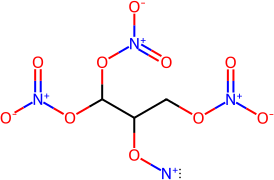
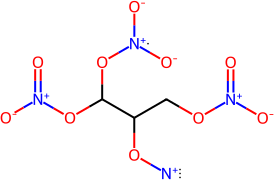
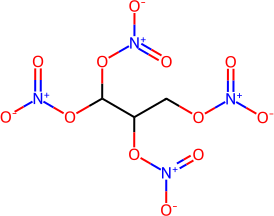
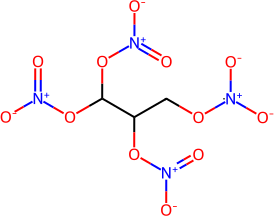
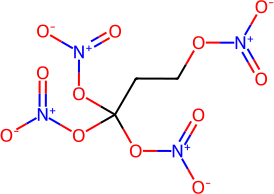
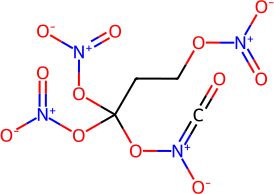
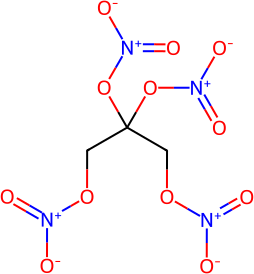
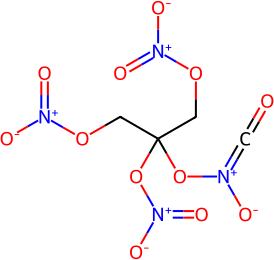
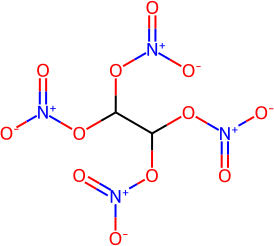
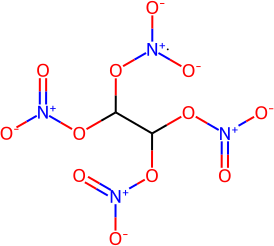
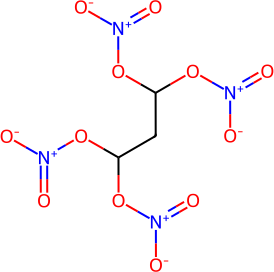
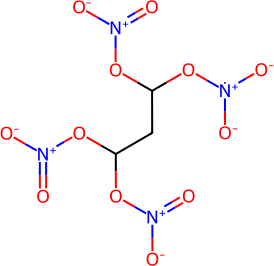
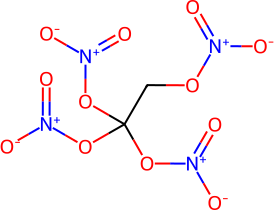
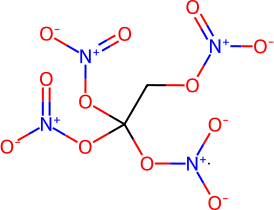
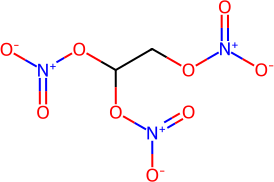
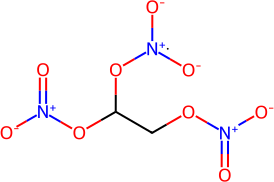
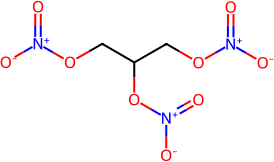
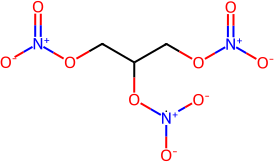

In [ ]:
# Use MolFrame to display 2D representation of derivatives
from mol_frame import mol_frame as mf
import pandas as pd
from rdkit.Chem import PandasTools

# Read in CSV file
df = pd.read_csv('NewDerivativesNG.csv')

# Show CSV using MolFrame
molf = mf.MolFrame()
molf.data = df
molf.show()

In [ ]:
## Generate a Gaussian input file for each derivative in the CSV (SMILES)

import pandas as pd
import os
from rdkit import Chem
from rdkit.Chem import AllChem

# Read the CSV file
df = pd.read_csv('NewDerivativesNG.csv')

folder_name = 'New_Derivatives' # Create a new folder to store the files

os.makedirs(folder_name, exist_ok=True)

for index, row in df.iterrows():
    # Retrieve the SMILES code from the 'SMILES' column
    smiles = row['Smiles']

    # Create a molecule from the SMILES code
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol)

    # Generate the Gaussian input file
    file_name = f'{row["NUM"]}.gjf'
    file_path = os.path.join(folder_name, file_name)

    with open(file_path, 'w') as f:
        f.write('%nprocshared=24\n') # change with your computer capacity
        f.write('%mem=120GB\n') # change with your computer capacity
        f.write('# HF/6-31G(d) Opt Freq\n\n') # change with your computer capacity
        f.write(f'{row["Smiles"]} geometry optimization\n\n')
        f.write('0 1\n')

        conf = mol.GetConformer()
        for atom in mol.GetAtoms():
            pos = conf.GetAtomPosition(atom.GetIdx())
            f.write(f'{atom.GetSymbol()}    {pos.x}    {pos.y}    {pos.z}\n')

        f.write('\n\n')

In [ ]:
## Create batch control file for Gaussian based on existing .gjf files
## Note: Put the *.bcf and folder containing *.gjf files in the same directory.
## Create the folder for calculations in the *.gjf folder.

import os

folder_path = r"New_Derivatives"  # Path to the folder containing the .gjf files
folder_path2 = r"New_Derivatives"  # Path to the folder where calculations will be performed
output_file = "New_Derivatives.bcf"  # Name of the output BCF file

bcf_code = '''!
!batch file
!start=1
!\n'''

gjf_files = [file for file in os.listdir(folder_path) if file.endswith(".gjf")]

for gjf_file in gjf_files:
    gjf_path = os.path.join(folder_path2, gjf_file)
    out_path = os.path.join(folder_path2, gjf_file.replace(".gjf", ".out"))
    bcf_code += f"{gjf_path} , {out_path}\n"

with open(output_file, 'w') as file:
    file.write(bcf_code)


In [ ]:
## Application Example: Extract all HOMO & LUMO from Gaussian output files for derivatives

import os
import pandas as pd
import regex as re

def extract_HOMO_LUMO(gaussian_output_file):
    with open(gaussian_output_file, 'rb') as file:
        total = file.read().decode('latin1')
        search = re.search('(?<=Alpha  occ. eigenvalues -- )(.*)([\r\n]\sAlpha virt. eigenvalues -- )(.*)',
                           total,
                           re.REVERSE)
        homo_energy = float(search.group(1).split()[-1])
        lumo_energy = float(search.group(3).split()[0])
        Bandgap_energy = lumo_energy - homo_energy
    return homo_energy, lumo_energy, Bandgap_energy

folder_path = './New_Derivatives'
results = []

for filename in os.listdir(folder_path):
    if filename.endswith(".out"):
        file_path = os.path.join(folder_path, filename)
        homo, lumo, bandgap = extract_HOMO_LUMO(file_path)
        results.append({'Compound_Id': filename.split('.')[0], 'HOMO': homo, 'LUMO': lumo, 'Bandgap': bandgap})

# Create a DataFrame from the results
df = pd.DataFrame(results)
df.Compound_Id = pd.to_numeric(df.Compound_Id).astype('Int64')
df = df.sort_values(by=['Compound_Id'])

# Save the DataFrame to a CSV file
df.to_csv('New_Derivatives_out.csv', index=False)


* using Smiles
* add b64:               (   18 |    6)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
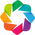

* using Mol_b64
* add img:               (   18 |    7)


:Scatter   [Compound_Id]   (Bandgap,Compound_Id,Image)
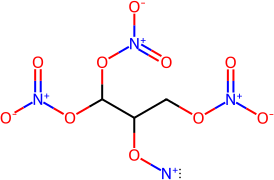
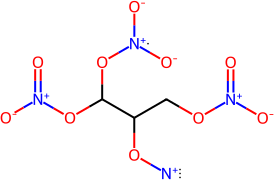
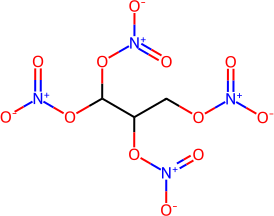
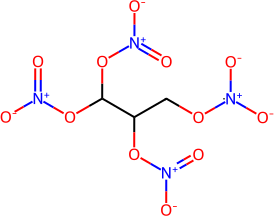
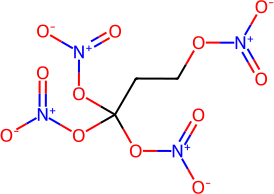
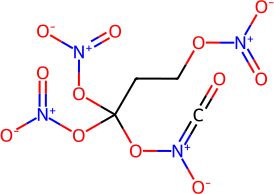
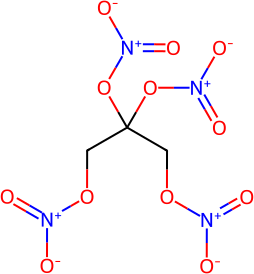
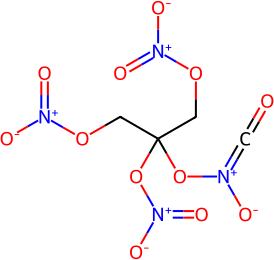
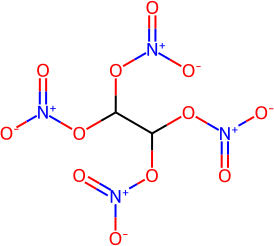
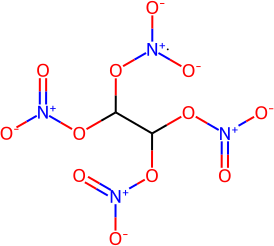
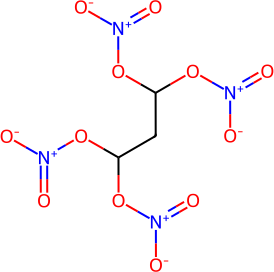
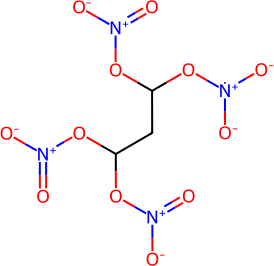
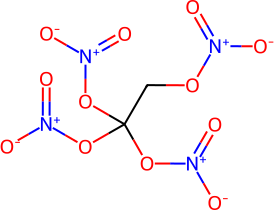
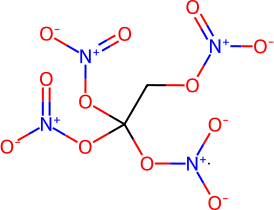
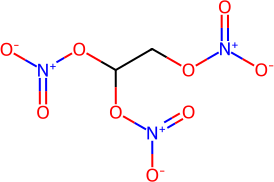
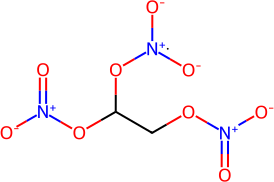
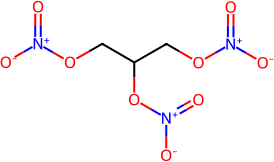
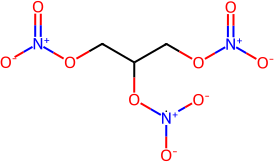

In [ ]:
## Application Example: Display Scatterplot of Derivatives with Bandgap Energy
import holoviews as hv
from mol_frame import mol_frame as mf


# Read in CSV file(s)
df = pd.read_csv('New_Derivatives_out.csv')
df2 = pd.read_csv('NewDerivativesNG.csv')
df.insert(0, "Smiles", df2['Smiles'].values, True)

# Show CSV using MolFrame
molf = mf.MolFrame(df)
molf = molf.add_b64()
hv.extension("bokeh")
molf.scatter("Compound_Id", "Bandgap")